# Scenario Analysis

Visualize some stuff from the baseline GRAIC scenario

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# data load methods
with open("./control_signals.txt", "r") as fp:
    traces = json.load(fp)


def get_xyz(point):
    return (point['x'], point['y'], point['z'])


def get_lanes_locations(record):
    c = np.array([get_xyz(t) for t in record["lane_marker"]["lane_markers_center"]["location"]])
    l = np.array([get_xyz(t) for t in record["lane_marker"]["lane_markers_left"]["location"]])
    r = np.array([get_xyz(t) for t in record["lane_marker"]["lane_markers_right"]["location"]])
    return l, c, r


def get_obstacles_verts(crecord):
    obstacles = crecord['obstacles']
    verts = []
    for obstacle in obstacles:
        pt = [(t['vertex_location']['x'], t['vertex_location']['y'], t['vertex_location']['z']) for t in obstacle['vertices_locations']]
        verts.append(np.array(pt))
    return verts

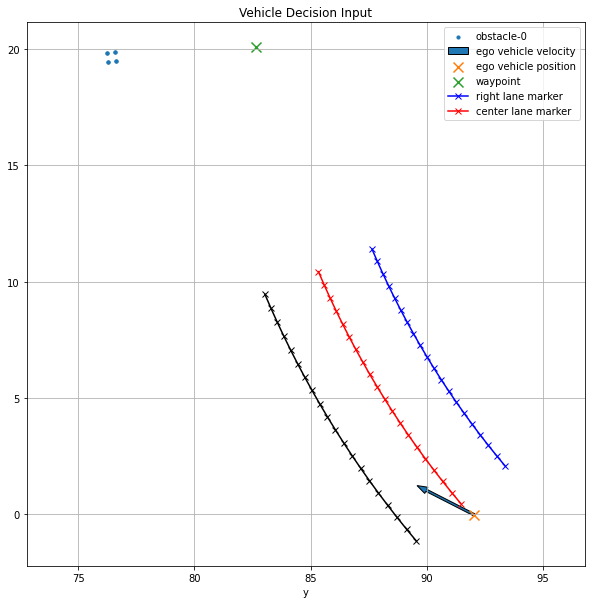

In [3]:
# plot data in control input
crecord = traces[350]

plt.figure(figsize=(10, 10))

lane_locs = get_lanes_locations(crecord)
obstacle_verts = get_obstacles_verts(crecord)
waypoint = get_xyz(crecord['waypoint']['location'])

state = crecord["state"][0]
velocity = crecord["state"][-1]

for idx, ovs in enumerate(obstacle_verts):
    plt.scatter(*ovs[:, :2].T, s=10, label=f'obstacle-{idx}')
    
plt.arrow(*state, *np.array(velocity)/4, width=0.1, label='ego vehicle velocity')

plt.scatter(*state, marker='x', s=100, label='ego vehicle position')
plt.scatter(*waypoint[:2], marker='x', s=100, label='waypoint')
plt.plot(*lane_locs[0][:, :2].T, '-xb', label='right lane marker')
plt.plot(*lane_locs[1][:, :2].T, '-xr', label='center lane marker')
plt.plot(*lane_locs[2][:, :2].T, '-xk')

plt.grid()
plt.legend()
plt.axis('equal')
plt.title("Vehicle Decision Input")
plt.xlabel('x')
plt.xlabel('y')
plt.savefig("control_input.pdf")

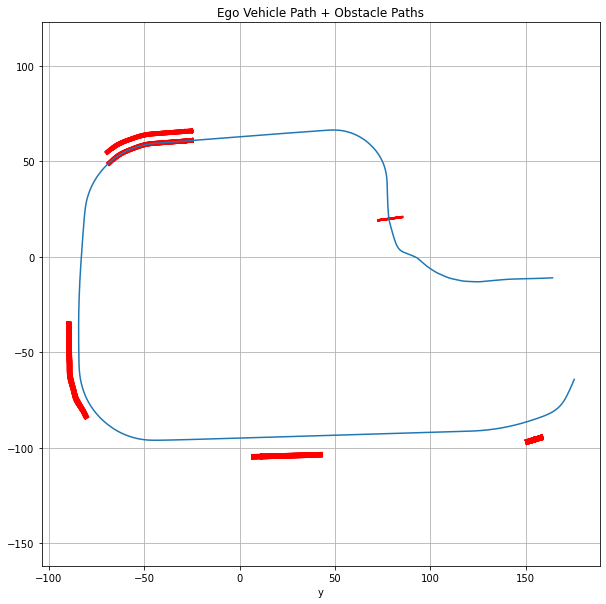

In [4]:
# plot the race -- ego vehicle path and obstacles
plt.figure(figsize=(10, 10))
obs_verts = [get_obstacles_verts(crecord) for crecord in traces]
obs_verts = [o for o in obs_verts if len(o) > 0]
obs_verts = np.vstack(obs_verts)

obs_verts = [get_obstacles_verts(crecord) for crecord in traces]
obs_verts = [o for o in obs_verts if len(o) > 0]

for ovs in obs_verts:
    for ov in ovs:
        plt.plot(*ov[:, :2].T, 'r')

positions = np.array([crecord['state'][0] for crecord in traces])

plt.plot(*positions[:, :2].T)
plt.grid()
plt.axis('equal')
plt.xlabel('x')
plt.xlabel('y')
plt.title('Ego Vehicle Path + Obstacle Paths')
plt.savefig("scenario_path.pdf")

In [5]:
from potential import *

In [6]:
pf = PotentialField(lane_penalty=3.0, obstacle_penalty=2.0, goal_reward=20.0)

# pack the current state into a CurrentState object
lane_locs = get_lanes_locations(crecord)
r = RoadSegment(*lane_locs[::-1])
cs = CurrentState(r, 
             state,
             velocity,
             get_xyz(crecord['waypoint']['location']), 
             [Obstacle(v) for v in get_obstacles_verts(crecord)])
field = pf.get_force_field(cs)

In [7]:
pf.get_reference(cs)

(array([91.10009037,  1.63678347]), array([-8.89298993, 16.96974539]))

In [ ]:
fig, ax = plt.subplots(figsize=(10.0, 10.0))

# get force magnitude
delta = 0.3
x = np.arange(70, 100, delta)
y = np.arange(-5, 25, delta)
X, Y = np.meshgrid(x, y)
pts = np.hstack((X.flatten()[:, np.newaxis], Y.flatten()[:, np.newaxis], np.zeros((len(X.flatten()), 1))))
forces = field(pts)
ZZ = np.linalg.norm(forces, axis=1)
ZZ = np.clip(ZZ, 0.0, np.median(ZZ)*2)
Z = ZZ.reshape(X.shape)
plt.contourf(X, Y, Z, cmap='bwr')

# markers
plt.scatter(*cs.cpos, s=100, marker='x', label='Current Position')
plt.scatter(*pf.get_reference(cs)[0], s=100, marker='x')
plt.scatter(*cs.waypoint[:-1], s=100, marker='x', label='Waypoint')
plt.scatter(*np.array([v.center for v in cs.obstacles])[:, :2].T, s=100, marker='x', label='Obstacle')
plt.plot(*pf.get_trajectory(cs, np.linspace(0, 1.3, 20))[:, :2].T, '-.k', label='Planned Path')
r.plot_road(ax)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Potential Path Planning")